In [1]:
%matplotlib inline

import matplotlib as mpl
import networkx as nx
import numpy as np
import random
import pandas as pd
import math
from copy import copy
from collections import defaultdict
from matplotlib import pyplot as plt
from itertools import combinations
from tqdm import tqdm
from joblib import Parallel, delayed

from graph_generators import grid_2d
from simulations import sample_graph_from_infection, simulate_IC, make_input
from plot_utils import add_colorbar, get_display_kwargs

In [20]:
seed = 123456
random.seed(seed)
np.random.seed(seed)

In [30]:
infp = 0.4
g = grid_2d(10, infp)
pos = {n: np.array(n) for n in g.nodes()}    

In [31]:
N = 5000
source, obs_nodes, infection_times, tree = make_input(g, infp, 0.05, sampling_method='late_nodes')
times_list = []
node2id = {n: i for i, n in enumerate(g.nodes())}

for i in range(N):
    sampled_g = sample_graph_from_infection(g)
    times, tree = simulate_IC(sampled_g, s=source, is_g_sampled=True)
    times = [times[n] for n in g.nodes()]
    times_list.append(times) 
    
times_array = np.array(times_list)    

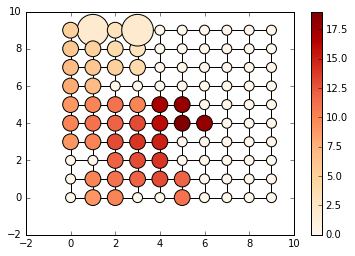

In [32]:
kwargs =get_display_kwargs(g, infection_times, obs_nodes=obs_nodes)
nx.draw_networkx(g, pos=pos, with_labels=False, **kwargs)
add_colorbar(kwargs['node_color'])

In [33]:
def extract_non_inf(arr):
    return arr[np.invert(np.isinf(arr))]

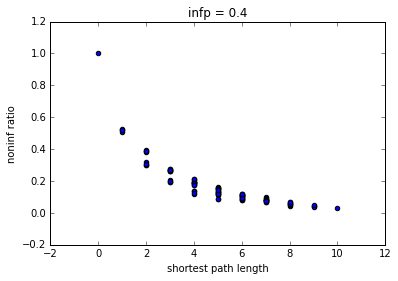

In [34]:
sp_len = nx.shortest_path_length(g, source=source)
lens = list(map(sp_len.__getitem__, g.nodes()))
noninf_ratio = list(map(lambda n: np.count_nonzero(np.invert(np.isinf(times_array[:, node2id[n]]))) / N, g.nodes()))
plt.scatter(lens, noninf_ratio)
plt.xlabel('shortest path length')
plt.ylabel('noninf ratio')
plt.title('infp = {}'.format(infp))

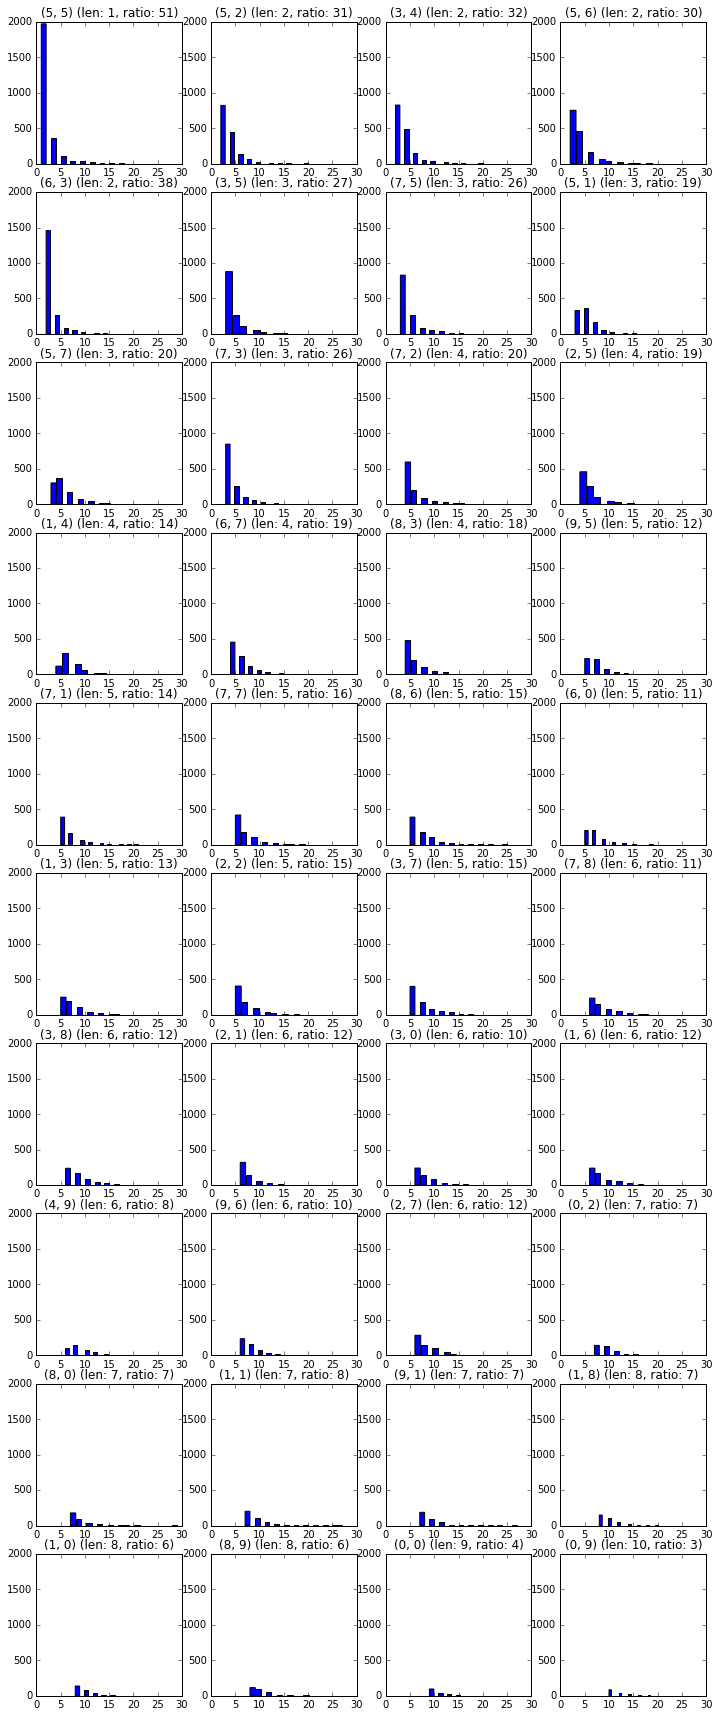

In [36]:
plot_cnts = 40
w = 3
ncol = 4
nrow = math.ceil(plot_cnts / ncol)
fig, axes = plt.subplots(nrow, ncol, figsize=(ncol * w, nrow * w))
sampled_nodes = random.sample(list(set(g.nodes()) - {source}), plot_cnts)

sampled_nodes = sorted(sampled_nodes, key=sp_len.__getitem__)

for n, c in zip(sampled_nodes, range(plot_cnts)):
    i, j = int(c / ncol), c % ncol
    ax = axes[i][j]
    pts = extract_non_inf(times_array[:, node2id[n]])
    ax.hist(pts, bins=20)
    ax.set_xlim(0, 30)
    ax.set_ylim(0, 2000)
    ax.set_title('{} (len: {}, ratio: {:.0f})'.format(n, sp_len[n], len(pts) / N * 100))